# Constraint Satisfaction Problems

This notebook presents, in an interactive way, the lecture notes of MIT's 16.413 course **Principles of Autonomy and Decision Making** for the chapter on **Constraint Satisfaction**.

The material below is highly influenced as well by **Chapter 6 Constraint Satisfaction Problems** of the book *Artificial Intelligence: A Modern Approach*.

Let us first import necessary modules and helper functions. Run the cell below:

In [1]:
from __future__ import print_function
from lib.notebook import psource, pseudocode, plot_NQueens
from lib.n_queens_csp import NQueensCSP, queen_constraint
from lib.backtracking import *

import sys

import lib.csp
from lib.sudoku.sudoku_csp  import Sudoku
from lib.constraint_propagation import AC3

from lib.search import NQueensProblem, depth_first_tree_search

# For plotting
%matplotlib inline

# Hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import time
import ipywidgets as widgets
from IPython.display import display

# Delete after development
%load_ext autoreload
%autoreload 2

# CONTENTS

 1. [**Introduction to Constraint Propagation Problems (L13 & L14)**](#Intro):
    1. *Definition*
    2. *Examples*

 2. [**Solving CSPs (L14 & L 15)**](#Constraint_Propagation):
    1. *Constraint Propagation in CSPs*:
        1. Arc-Consistency:
            1. Directed arc consistency
            2. Full arc consistency

        2. Propagation:
            1. AC-1:
                * Definition
                * Example: solving Sudoku with AC-1
                * Complexity Analysis
                * Soundness and Completeness
            2. AC-3:
                * Definition
                * Example: solving Sudoku with AC-3
                * Complexity Analysis
                * Soundness and Completeness
        3. Numerical constraints:
            1. Propagation for Integer Domains
            2. Pruning Integer Domains
        4. Global constraints:
            1. AllDiff
            2. Example: global vs local constraints NQueens
    2. *[Search in CSPs](#search_in_csps)*:
        1. [Generic Search](#generic_search):
            * Formulating CSPs as a state space search problem
            * Complexity
            * Example: NQueens with generic search (5 Queens)
        2. [Backtracking Search (BT)](#backtracking):
            * Definition
            * Complexity
            * Example: solving NQueens (15 Queens)
        3. [Backtracking Search with Forward Checking (BT-FC)](#backtracking_w_fc):
            * Definition
            * Complexity
            * Example: solving NQueens (30 Queens)              
        4. [**Backtracking while Maintaining Arc Consistency (BT-MAC)**](#backtracking_w_mac):
            * Definition
            * Complexity
            * Example: solving NQueens (X Queens)
        4. BT-DC with Dynamic Variable Ordering:
            * Definition
            * Complexity
            * Example: solving NQueens (1000 Queens)

    3. *Elimination for Constraints in CSPs*:
        1. Variable Elimination for Constraints:
            * Definition: join and project
            * Example
        2. Bucket elimination (Adaptive Consistency):
            * Definition
            * Example

 3. **Appendix**:
    1. Constraint Optimization Problem:
        1. Branch-and-Bound
        2. Example: using Map Coloring problem with cost added to the colors to use.
    2. Conflict-directed Back Jumping (CBJ)
        * Definition
        * Example
    3. Incremental Repair / Iterative Repair / Min-Conflict Heuristic
        * Definition
        * Example

## Introduction <a name="Intro"></a>

Constraint satisfaction problem represents states using a list of variables with assignments and
conditions for a solution in the form of constraints on the variables. This allows us to treat
the state space with structure - using a factored representation for each state contrary to the
black box view used in state space search problems.


Formally, Constraint Satisfaction Problem (CSP) can be defined as a triple of < X, D, C > where
X is a set of variables, D is the domain of each of the variables in V and C is the set of constraints
defining the problem. Each constraint in C can be thought of as a pair of scope S which is a
subset of V and a relation R between variables in S. The problem of having seeking a set with one
A and two B’s can be cast in the CSP framework with V = {A, B}, D = {1, 2} and constraint
C = {[{A, B}, {{1, 2}, {1, 1}}], [{A, B}, {{1, 2}, {2, 2}}]} where the first constraint tells that there
must be exactly one A and the second constraint imposes the fact that there must be two B’s. The
solution to the problem is when both the constraints are satisfied which is possible only when the
assignment is (1,2).

CSPs can be visualized using constraint graphs where the nodes represent the variables and the
edges represent the constraint between the variables connected by it. Any CSP can be represented
using a constraint graph because any constraint involving multiple variables can be converted to
binary variables by adding additional variables to the problem.

## Constraint Propagation <a name="Constraint_Propagation"></a>

Apart from searching the state space, constraint programming also allows us to perform specific
type of inference called constraint Propagation which helps in eliminating unwanted parts of the
state space based on the constraint satisfaction.

A single variable in a CSP is said to be node-consistent if all it’s unary constraints are satisfied.
We can use this to delete some values in the domain of the variable that doesn’t satisfy the unary
constraint on that variable. A network is node-consistent if all the variables in it are also nodeconstraint.

A variable in CSP is said to be arc-consistent if every value in its domain satisfies binary constraints
imposed on the variable. Similar to node consistency, checking for arc-consistency can help reduce the domain size of a variable before performing search. Algorithm 1 shown below describes a Revise procedure that ensures that a given node Xi is arc-consistent.

<img src="images/Algorithm_1.png">

## AC-1 and AC-3

AC-1 is a constraint propagation algorithm that repeatedly checks for arc-consistency between two nodes and removes those values in the domain of each of the two variables that are not consistent. The algorithm is described below:

<img src="images/Algorithm_2.png">

In AC-1, the domain of a variable is changed by deleting the values in the variable’s domain that are arc inconsistent with another variable. We notice that everytime the domain of the variable shrinks, some equivalent values in other variables now become inconsistent. AC-1 doesn’t take advantage of this and hence it must be run iteratively until the domain of all the variables don’t change. AC-3, on the contrary, tries to take advantage of this fact by using a queue that has information about the next arcs to be checked based on the modifications made in the current iteration. This leads to a much faster constraint propagation. The algorithm is described below

<img src="images/Algorithm_3.png">

In [2]:
easy1 = '..3.2.6..9..3.5..1..18.64....81.29..7.......8..67.82....26.95..8..2.3..9..5.1.3..'
e = Sudoku(easy1)
e.display(e.infer_assignment())

AC3(e); e.display(e.infer_assignment())

. . 3 | . 2 . | 6 . .
9 . . | 3 . 5 | . . 1
. . 1 | 8 . 6 | 4 . .
------+-------+------
. . 8 | 1 . 2 | 9 . .
7 . . | . . . | . . 8
. . 6 | 7 . 8 | 2 . .
------+-------+------
. . 2 | 6 . 9 | 5 . .
8 . . | 2 . 3 | . . 9
. . 5 | . 1 . | 3 . .
4 8 3 | 9 2 1 | 6 5 7
9 6 7 | 3 4 5 | 8 2 1
2 5 1 | 8 7 6 | 4 9 3
------+-------+------
5 4 8 | 1 3 2 | 9 7 6
7 2 9 | 5 6 4 | 1 3 8
1 3 6 | 7 9 8 | 2 4 5
------+-------+------
3 7 2 | 6 8 9 | 5 1 4
8 1 4 | 2 5 3 | 7 6 9
6 9 5 | 4 1 7 | 3 8 2


## <a name="search_in_csps"></a>2. Search in CSPs

Constraint propagation alone is not sufficient to solve many CSPs. In this case, a solution must be found using search algorithms.

In this section, we will explain different search algorithms used to solve CSPs.
The section is organized as follows:

1. [Generic Search](#generic_search):
    * Formulating CSPs as a state space search problem
    * Complexity
    * Example: NQueens with generic search (5 Queens)
2. [Backtracking Search (BT)](#backtracking):
    * Definition
    * Complexity
    * Example: solving NQueens (15 Queens)
3. [Backtracking Search with Forward Checking (BT-FC)](#backtracking_w_fc):
    * Definition
    * Complexity
    * Example: solving NQueens (30 Queens)              
4. [**Backtracking while Maintaining Arc Consistency (BT-MAC)**](#backtracking_w_mac):
    * Definition
    * Complexity
    * Example: solving NQueens (X Queens)
4. BT-DC with Dynamic Variable Ordering:
    * Definition
    * Complexity
    * Example: solving NQueens (1000 Queens)

<div class="alert alert-block alert-danger">
<b>TODO:</b> Provide example, slide 79 seems to show a case where arc-consistency alone does not solve the problem (but I think that path consistency would do constraint propagation up to the solution...). Can we find a sudoku example where we cannot rule out all possibilities by doing constraint propagation?
</div>

### <a name="generic_search"></a> a. Generic Search

#### Formulating CSPs as a state space search problem

CSPs can be formulated using the State Space search representation.
In particular, we can express a CSP as follows:
* **State**:
    - We can define as state a **partial assignment** to variables made thus far.
    For example, if we have variables $A$, $B$ and $C$ whith respective domains $[a_1, a_2]$, $[b_1, b_2]$, and  $[c_1, c_2]$ a partial assignment would be for example $\{A=a_2, C=c_1\}$, another one could be $\{B=b_2, C=c_2\}$. In contrast, we consider a **complete assignment** one where all variables would be assigned, such as $\{A=a_2, B=b_1, C=c_1\}$. Note that a complete assignment is still a (kind-of) partial assignment.
* **Initial State**:
    - Initially the state would be **no assignment**, which we can represent as the empty set $\{\}$.
* **Operator/Action**:
    - We also need to define an action/operator to frame a CSP into a State Space search problem.
    In our case, this would correspond to the fact of **adding a new assignment**.
    In other words, our operator corresponds to the action of assigning a value to a yet unassigned variable $X=x$, which expands the State by one element. For example, if we start from the initial state $\{\}$, and we proceed with the action $X=x,$ we end up with a new state $\{X=x\}$, which is itself a partial assignment.
* **Goal Test**:
    - As in all State Space search problems, we need to define what is our goal state.
    In our case, this is achieved when all variables are assigned (meaning we have a **complete assignment**) and all constraints are satisfied (which we refer to as a **consistent assignment**).

Once the problem is formulated as a State Space search problem, we can use standard search algorithms such as:
* Breadth first search
* Depth first search
* Depth-limited search

to solve the given problem.

#### Complexity

Unfortunately, given a CSP with $n$ variables with a domain size of $d$, results in a branching factor at the top level of $nd$.
This is because any of the $n$ variables can be assigned any of $d$ values.
Once a variable has been assigned a value, we are still left with $n − 1$ variables which can be assigned $d$ values. By induction, we end up with a tree having $n!d^n ∼ O((nd)^n)$ leaves, which is even larger than the possible $d^n$ complete assignments!

Nevertheless, we can observe than in a CSP **the order when assigning variables does not influence the solution**. This property is known as **commutativity**. More specifically, a problem is commutative if the order of application of any given set of actions does no effect on the outcome. Therefore, there is no need to consider all variables at each level of the search tree, but just one at a time. 

This makes sense intuitvely, for example, if we consider the coloring map problem, we might decide whether to color a certain region red or blue, but we would not decide between coloring one region red or another region blue. Therefore, the number of leaves is reduced to $d^n$, where we just have to decide on an assignment for each variable at a time.

#### Example: NQueens with generic search (5 Queens)

The N-queens puzzle is the problem of placing N chess queens on an N×N chessboard in a way such that no two queens threaten each other. Here N is a natural number. 

Thus, no two queens can share a common row, column, or diagonal. We will use the following representation in this problem.
- Each variable specifies the row on which a particular queen is placed. Each queen is identified (indexed) with a column of the board. This automatically ensures that the queens will not share columns.
- The variable domains are the available row indices.
- The constraints between the variables specify that the corresponding queens do not share a row or diagonal.

Using the State Space search formulation, we express the NQueens Problem as follows:
* **State**:
    - We can define as state a **partial assignment** of Queens (variables) made thus far.
* **Initial State**:
    - Initially the state would be **no assignment**, which, in our case, we represent as a value of -1 for all variables.
* **Operator/Action**:
    - Our action consists in **adding a new Queen** to the board.

In [3]:
psource(NQueensProblem.actions)

* **Goal Test**:
    - This state is achieved when all variables are assigned (meaning we have a **complete assignment**) and all constraints are satisfied.

Below you can actually see the NQueens Problem coded as a State Search Problem:

In [4]:
psource(NQueensProblem.goal_test)

Let us apply a generic search algorithm to the NQueens problem.
For example, let us use Depth First Search to find a solution.
Note that we are already applying the commutativity property of CSPs that we discussed previously.
Therefore, we are avoiding $n!$ redundant paths, thereby making the depth first search faster.

Feel free to change the number of queens used, but be aware that depth first search will start struggling with numbers larger than 7.

Time taken to solve 5 Queens problem using Backtracking: 0.003226 seconds


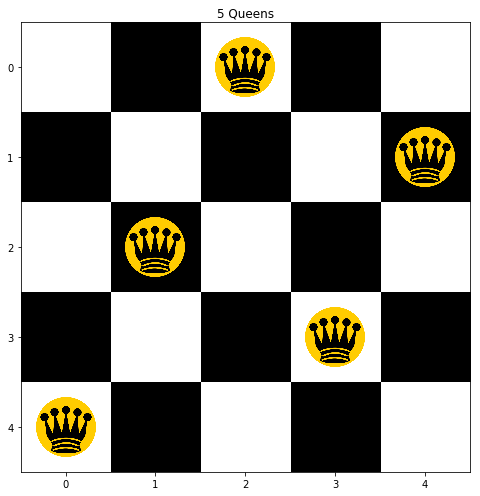

In [5]:
N = 5

n_queens_problem = NQueensProblem(N, pruning=False)

start_time = time.time()
solution = depth_first_tree_search(n_queens_problem).solution()
end_time = time.time()
print("Time taken to solve %s Queens problem using Backtracking: %f seconds"% (N, end_time - start_time))

plot_NQueens(solution)

### <a name="backtracking"></a> b. Backtracking

Backtracking search suits the commutative property of CSPs, as it consists on a depth-first search that chooses one variable at a time. 

Moreover, it makes use of another property of CSPs that is **extensions to inconsistent partial assignments are always inconsistent**.
The backtracking search **backtracks** when an inconsistent partial assignment is reached. 

We show below the actual backtracking search algorithm (pseudo-code), as presented in [5]. 

<a name="backtracking_algorithm"></a>
<img src="images/backtracking_algorithm.png" alt="drawing" width="600">

In plain words, the algorithm first chooses an unassigned variable, and loops over its domain by picking one value at
a time. Every time a value is taken, if it is consistent, then the algorithm continues to look for a
solution. If it is not consistent, then the algorithm backtracks by trying with another value instead.

The backtracking algorithm presented above makes use of a set of sub-functions that we detail
below:
* **Select-Unassigned-Variable(csp, assignment)**:
    - Decides which variable should be assigned next.
* **Order-Domain-Values(var, assignment, csp)**:
    - Decides the order in which the values of the variable should be tried. We will see in section 2.3.4 how modifications of this and the previous function result in different general purpose heuristics.
* **Inference(csp, var, assignment)**:
    - Every time a variable has been assigned a value, there is the opportunity to further reduce the domains of the rest of unassigned variables using inference, such as checking for arcconsistency. While the call to this function is not strictly necessary, we will see in section 2.3.3 that interleaving search and inference results in a more efficient algorithm.


    
The source code to implement this pseudo-code is actually fairly close to the actual implementation.
Below the actual source code in python:

In [6]:
psource(backtracking_search)

<a name="backtrack_pseudo"></a>

#### Example: solving NQueens using simple backtracking algorithm

We can encode the NQueens problem as follows, for a N×N board:
* **Variables**:
    * Each of the Queen's positions on the board: $X_i = \text{row of queen in column i}$
* **Domains**:
    * The domain of each variable is just the number of rows on the board: $X_i \in \mathcal{X} = \{0, ..., N-1\}$
* **Constraints**:
    * Queens do not share rows. This is equivalent to requiring all variables $X_i$ to be of different value: $AllDiff(X_i)$
    * Only one queen in a column. This is satisfied by default because of the variable encoding.
    * No two queens can share a common diagonal. This can be encoded as follows:
         - Assume we have a variable $X_i$, or, in other words, a queen in the row given by the value of $X_i$ and column given by the index $i$.
         Then, no queen can be represented by $X_k$ if the following condition holds: $X_k = X_i - (k - i)$.
         This is only for diagonals going _down_ from left to right.
         What about the other diagonal? The one going _up_ from left to right can be similarly encoded changing just one sign: $X_k = X_i + (k - i)$. Since we need to check this constraint for all the queens on the board, we have:
             ```pseudo
                for all X_i:
                    for 0:k, k != i, k < N:
                       X_k != X_i - (k - i)
                       X_k != X_i + (k - i)
            ```

            But this is actually equivalent to check that the value of $X_k - k$ is different for all $k$ (same for  $X_k + k$)! Therefore, we can use the $AllDiff(\cdot)$ function to encode this constraint as well.
        
 Below you can find the actual NQueens problem formulated as explained here.
 Note that we define the variables and domains (ignore for now the `curr_domains`, `pruned` and `constraints` variables).
 Also, the constraints are encoded in the method `is_consistent` below.
This method checks that an assignment is consistent given the constraints, as required by the function `csp.is_consistent(var, val, assignment)` in the [backtrack code](#backtrack_pseudo).

In [7]:
psource(NQueensCSP)

Time taken to solve 10 Queens problem using Backtracking: 0.015091 seconds


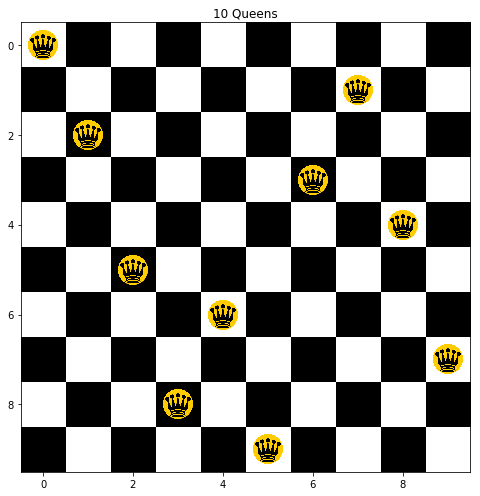

In [8]:
# Create NQueens problem.
N = 10
n_queens = NQueensCSP(N)

# Solve the problem using Backtracking. Store timing.
start_time = time.time()
solution = backtracking_search(n_queens)
end_time = time.time()
print("Time taken to solve %s Queens problem using Backtracking: %f seconds"% (N, end_time - start_time))
plot_NQueens(solution)


<div class="alert alert-block alert-danger">
<b>TODO:</b> Implement algorithm in notebook and play with different implementations of the subfunctions. Show practical examples for Sudoku example
</div>

### <a name="backtracking_w_fc"></a> c. Backtracking with Forward Checking

By modifying the call to the function _Inference_ in the backtracking algorithm presented [above](#backtracking_algorithm), we can interleave search with inference to reduce the domain of yet unassigned variables, thereby reducing the search space. 

A simple form of inference is **forward checking**, which consists in establishing arc-consistency for the recently assigned variable with respect to all connected, yet unassigned, variables.

#### Complexity
Question: Full propagation is O(ek3),
How much propagation should we do?
Very little (except for big problems).
Forward Checking (FC):
Check arc consistency ONLY for
10/29/2018
22
arcs that terminate on the new assignment. 16.410-13
[O(ek) total]

#### Example: NQueens

Checking arc-consistency for the NQueens problem is simple, as we just need to define a function 
The constraint that needs to be passed to the CSP is defined in the **queen_constraint** function. 
The constraint is satisfied (true) if A, B are really the same variable, or if they are not in the same row (equivalent to having the same value), down diagonal, or up diagonal.

 Time taken to solve 15 Queens problem using Backtracking with Forward Checking: 0.038904 seconds


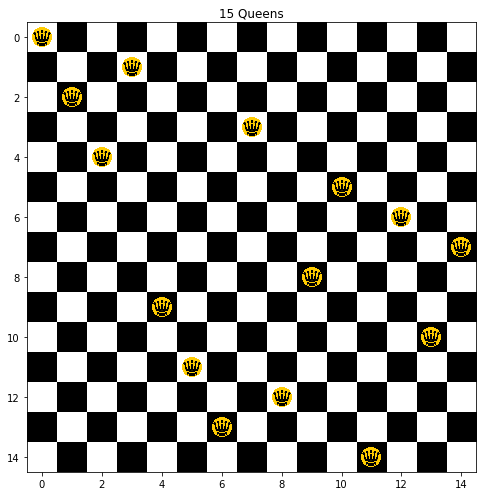

In [9]:
# Create NQueens problem.
N = 15
n_queens = NQueensCSP(N)

# Solve the problem using Backtracking with Forward Checking (fc flag set to True). Store timing.
start_time = time.time()
solution = backtracking_search(n_queens, inference=forward_checking)
end_time = time.time()
print(" Time taken to solve %s Queens problem using Backtracking with Forward Checking: %f seconds"% (N, end_time - start_time))
plot_NQueens(solution)

The constraint that needs to be passed to the CSP is defined in the **queen_constraint** function. 
 The constraint is satisfied (true) if A, B are really the same variable, or if they are not in the same row (equivalent to having the same value), down diagonal, or up diagonal.

In [10]:
psource(queen_constraint)

<div class="alert alert-block alert-danger">
<b>TODO:</b> Add at this point an example of forward-checking in sudoku problems
</div>

### <a name="backtracking_w_mac"></a>d. Backtracking while Maintaining Arc Consistency (BT-MAC)

#### Definition
<div class="alert alert-block alert-danger">
<b>TODO:</b> Definition
</div>

#### Complexity
<div class="alert alert-block alert-danger">
<b>TODO:</b> Complexity
</div>

#### Example: solving NQueens (X Queens)
<div class="alert alert-block alert-danger">
<b>TODO:</b> Example: solving NQueens (X Queens)
</div>
<div class="alert alert-block alert-danger">
<b>TODO:</b> What is the actual number for X above, aka how many Queens can we solve with MAC?
</div>

 Time taken to solve 15 Queens problem using Backtracking with Forward Checking: 0.095257 seconds


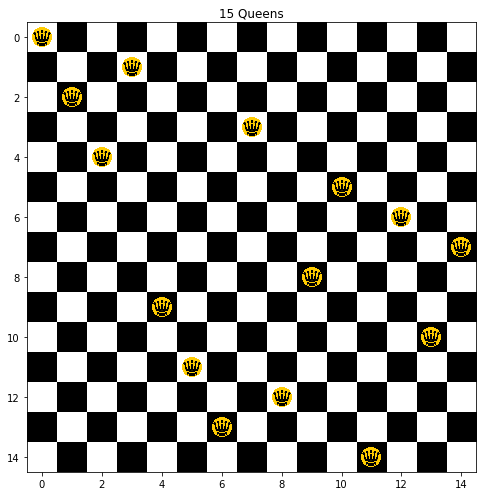

In [11]:
# Create NQueens problem.
N = 15
n_queens = NQueensCSP(N)

# Solve the problem using Backtracking with Forward Checking (fc flag set to True). Store timing.
start_time = time.time()
solution = backtracking_search(n_queens, inference = mac)
end_time = time.time()
print(" Time taken to solve %s Queens problem using Backtracking with Forward Checking: %f seconds"% (N, end_time - start_time))
plot_NQueens(solution)

 ## Dynamic Variable Ordering
 
The function Select-Unassigned-Variable in algorithm 4 could be trivially set to pick the next unassigned variable in order, or alternatively pick a random variable each time. Nevertheless, these strategies rarely result in an efficient search. <font color='red'> TODO: Code an example where this is the case.</font> The Most Constrained Variable (MCV) heuristic. It consists in taking as next variable the one having the smallest domain. It is therefore also known as the minimum-remaining-values heuristic, or the fail-first heuristic. The advantage of using MCV is clear when we have a variable that has no legal values left, in this case, the MRV will select this variable first and failure will be detected immediately, which avoids further searches through other variables.

The MCV heuristic usually performs better than random or static ordering, sometimes by a factor
of 1000 or more, although the results vary widely depending on the problem. <font color='red'> TODO: Can we
show this using the Sudoku implementation? </font> We can also modify the function Order-Domain-Values in algorithm 4 to reach a solution faster. The Least Constraining Value (LCV) heuristic consists in taking as next value for the variable in hand the one that reduces by the least amount the domains of the neighbor variables. <font color='red'> TODO: Give Sudoku example or map coloring. </font> The heuristic is therefore just trying to leave the maximum flexibility for subsequent variable assignments. Note that if our objective is to list all possible solutions, this heuristic does not bring any advantage.

## Bucket Elimination

The idea of join and project used to eliminate variables when solving system of linear equation can be extended to constraints. This is made possible by bucket elimination. 

$\textbf{Join operation}$ for constraints is shown below:
<img src="images/pic_1.png">

$\textbf{Project operation}:$ C2 = $\pi_{2}C_{21}$
<img src="images/pic_2.png">

Important ideas behind bucket elimination are as follows:

* Eliminate: Derive all consequences that depend on each Vi
    by joining all constraints involving Vi

* Solve: Encode all solutions to constraints $\phi$,
    by systematically eliminating all variables.

* Generate: all solutions without backtrack search, by propagating.

In [12]:
# DELETE once we finish this notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helper Functions

We will now implement a few helper functions that will allow us to visualize the Coloring Problem; we'll also make a few modifications to the existing classes and functions for additional record keeping. To begin, we modify the **assign** and **unassign** methods in the **CSP** in order to add a copy of the assignment to the **assignment_history**. We name this new class as **InstruCSP**; it will allow us to see how the assignment evolves over time. 

In [13]:
import copy
class InstruCSP(NQueensCSP):
    
    def __init__(self, N):
        super().__init__(N)
        self.assignment_history = []
        
    def is_consistent(self, var, val, assignment):
        attempt_assignment = {var: val}
        attempt_assignment.update(assignment)
        if len(self.assignment_history) > 0:
            # Second or older assignemnt, we can re-use the pruned domains, they will be overwritten
            # if is_consistent returns false, as we won't get into track_pruned_domains_for_display
            self.assignment_history.append([attempt_assignment, self.assignment_history[-1][1]])
        else:
            # First assignment, therefore there are no pruned domains...
            self.assignment_history.append([attempt_assignment, None])
        
        #runed_domains = copy.deepcopy(self.domains)
        #or var, val in self.curr_domains:
        #   pruned_domains[var].remove(val)
        #elf.pruned_domains_history.append[pruned_domains]
        return super().is_consistent(var, val, assignment)
        
    #def assign(self, var, val, assignment):
        #super().assign(var, val, assignment)
        #self.assignment_history.append(copy.deepcopy(assignment))
        
    def track_pruned_domain_for_display(self):
        pruned_domains = copy.deepcopy(self.domains)
        for var, values in self.curr_domains.items():
            for val in values:
                pruned_domains[var].remove(val)
        self.assignment_history[-1] = [self.assignment_history[-1][0], pruned_domains]
        return super().track_pruned_domain_for_display()
    
    def unassign(self, var, assignment):
        super().unassign(var, assignment)
        pruned_domains = copy.deepcopy(self.domains)
        for var, values in self.curr_domains.items():
            for val in values:
                pruned_domains[var].remove(val)
        self.assignment_history.append([assignment, pruned_domains])
        
        #runed_domains = copy.deepcopy(self.domains)
        #or var, val in self.curr_domains:
        #   pruned_domains[var].remove(val)
        #elf.pruned_domains_history.append[pruned_domains]

Next, we define **make_instru** which takes an instance of **CSP** and returns an instance of **InstruCSP**.

In [14]:
def make_instru(csp):
    return InstruCSP(len(csp.variables))

## N-QUEENS VISUALIZATION

Just like the Graph Coloring Problem, we will start with defining a few helper functions to help us visualize the assignments as they evolve over time. The **make_plot_board_step_function** behaves similar to the **make_update_step_function** introduced earlier. It initializes a chess board in the form of a 2D grid with alternating 0s and 1s. This is used by **plot_board_step** function which draws the board using matplotlib and adds queens to it. This function also calls the **label_queen_conflicts** which modifies the grid placing a 3 in any position where there is a conflict.

In [15]:
def label_queen_conflicts(assignment,grid):
    ''' Mark grid with queens that are under conflict. '''
    for col, row in assignment.items(): # check each queen for conflict
        conflicts = {temp_col: temp_row for temp_col, temp_row in assignment.items() if (temp_row == row and temp_col != col or (temp_row+temp_col == row+col and temp_col != col) or (temp_row-temp_col == row-col and temp_col != col))}
        
        # Place a 3 in positions where this is a conflict
        for col, row in conflicts.items():
            grid[row][col] = 3

    return grid

def make_plot_board_step_function(instru_csp):
    '''ipywidgets interactive function supports
       single parameter as input. This function
       creates and return such a function by taking
       in input other parameters.
    '''
    n = len(instru_csp.variables) 
    
    def plot_board_step(iteration):
        ''' Add Queens to the Board.'''
        data = instru_csp.assignment_history[iteration]
        #pruned_domains = instru_csp.pruned_domains_history[iteration]
        
        grid = [[(col+row+1)%2 for col in range(n)] for row in range(n)]
        grid = label_queen_conflicts(dict(data[0]), grid) # Update grid with conflict labels.
        # color map of fixed colors
        cmap = matplotlib.colors.ListedColormap(['white','black','red'])
        bounds=[0,1,2,3] # 0 for white 1 for black 2 onwards for conflict labels (red).
        norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
        
        plot_NQueens(data[0], data[1], n, grid, cmap, norm)
    
    return plot_board_step

def make_visualize(slider):
    ''' Takes an input a slider and returns 
        callback function for timer and animation
    '''
    
    def visualize_callback(Visualize, time_step):
        if Visualize is True:
            for i in range(slider.min, slider.max + 1):
                slider.value = i
                time.sleep(float(time_step))
    
    return visualize_callback
    

In [16]:
twelve_queens_csp = NQueensCSP(12)
backtracking_instru_queen = make_instru(twelve_queens_csp)
result = backtracking_search(backtracking_instru_queen)

In [17]:
backtrack_queen_step = make_plot_board_step_function(backtracking_instru_queen) # Step Function for Widgets

In [18]:
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)
matplotlib.rcParams['font.family'].append(u'Dejavu Sans')

iteration_slider = widgets.IntSlider(min=0, max=len(backtracking_instru_queen.assignment_history)-1, step=1, value=0)
w=widgets.interactive(backtrack_queen_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:', options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step = time_select)
display(a)



interactive(children=(IntSlider(value=0, description='iteration', max=3041), Output()), _dom_classes=('widget-…

interactive(children=(ToggleButton(value=False, description='Visualize'), ToggleButtons(description='Extra Del…

### BT-FC

In [19]:
twelve_queens_csp = NQueensCSP(30)
backtracking_instru_queen = make_instru(twelve_queens_csp)
result = backtracking_search(backtracking_instru_queen, inference=forward_checking)

# DISPLAYing
backtrack_queen_step = make_plot_board_step_function(backtracking_instru_queen) # Step Function for Widgets
iteration_slider = widgets.IntSlider(min=0, max=len(backtracking_instru_queen.assignment_history)-1, step=1, value=0)
w=widgets.interactive(backtrack_queen_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:', options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step = time_select)
display(a)

KeyboardInterrupt: 

### BT-MAC

In [ ]:
twelve_queens_csp = NQueensCSP(30)
backtracking_instru_queen = make_instru(twelve_queens_csp)
result = backtracking_search(backtracking_instru_queen, inference=mac)

# DISPLAYing
backtrack_queen_step = make_plot_board_step_function(backtracking_instru_queen) # Step Function for Widgets
iteration_slider = widgets.IntSlider(min=0, max=len(backtracking_instru_queen.assignment_history)-1, step=1, value=0)
w=widgets.interactive(backtrack_queen_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:', options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step = time_select)
display(a)

#### Backtracking using Minimum Remaining Values heuristic

In [ ]:
twelve_queens_csp = NQueensCSP(12)
backtracking_instru_queen = make_instru(twelve_queens_csp)
result = backtracking_search(backtracking_instru_queen, select_unassigned_variable=mrv)


In [ ]:
backtrack_queen_step = make_plot_board_step_function(backtracking_instru_queen) # Step Function for Widgets
iteration_slider = widgets.IntSlider(min=0, max=len(backtracking_instru_queen.assignment_history)-1, step=1, value=0)
w=widgets.interactive(backtrack_queen_step,iteration=iteration_slider)
display(w)

visualize_callback = make_visualize(iteration_slider)

visualize_button = widgets.ToggleButton(description = "Visualize", value = False)
time_select = widgets.ToggleButtons(description='Extra Delay:', options=['0', '0.1', '0.2', '0.5', '0.7', '1.0'])

a = widgets.interactive(visualize_callback, Visualize = visualize_button, time_step = time_select)
display(a)

#### Solving HARD Sudoku Problem!

In [ ]:
harder1 = '4173698.5.3..........7......2.....6.....8.4......1.......6.3.7.5..2.....1.4......'
h = Sudoku(harder1)
h.display(h.infer_assignment())
print()
solution = backtracking_search(h, select_unassigned_variable=mrv, inference=forward_checking)
h.display(solution)